In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


Distiller Class

In [22]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

Creating Teacher and Student Model

In [23]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen_with_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-IMG_SET',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-IMG_SET', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='validation'
    ) # set as validation data

#input_img = Input(shape=(224, 224, 3))

Found 2216 images belonging to 5 classes.
Found 554 images belonging to 5 classes.


In [24]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
# from keras.layers.merge import concatenate

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

In [25]:
# Create the teacher
from tensorflow.keras.models import load_model
#teacher = load_model('/content/drive/MyDrive/RESNET_152(ADAM_0.01).h5')
#teacher = (("/content/drive/MyDrive/RESNET_152(ADAM_0.01).h5"),
   # [
      #  keras.Input(shape=(28, 28, 1)),
       # layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
       # layers.LeakyReLU(alpha=0.2),
      #  layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
       # layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
      #  layers.Flatten(),
       # layers.Dense(10),
   #() ],
    #name="teacher"

from tensorflow.keras.applications import DenseNet169
import tensorflow.keras.applications


# Load DenseNet-169 model without top layers
densenet169_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
DENSENET_169 = keras.models.Sequential()

# Set layers in densenet169_model to non-trainable
for layer in densenet169_model.layers:
    layer.trainable = False

# Add layers to the model
DENSENET_169.add(densenet169_model)
DENSENET_169.add(Flatten())
DENSENET_169.add(Dropout(0.2))
DENSENET_169.add(Dense(1024, activation='relu'))
DENSENET_169.add(Dropout(0.2))
DENSENET_169.add(Dense(512, activation='relu'))
DENSENET_169.add(Dense(5, activation='softmax'))

DENSENET_169.summary()

teacher= DENSENET_169

# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),

        layers.Conv2D(16, (5, 5), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),


        layers.Conv2D(48, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),


        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

        layers.Flatten(),
        layers.Dense(600),
        layers.Dense(300),
        layers.Dense(150),
        layers.Dense(5),


    ],
    name="student",
)
student.summary()

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)


51877672/51877672 [==============================] - 18s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_5 (Flatten)         (None, 81536)             0         
                                                                 
 dropout_5 (Dropout)         (None, 81536)             0         
                                                                 
 dense_14 (Dense)            (None, 1024)              83493888  
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                      

Train the Teacher Network and Distill the Teacher weights to Student

In [26]:
 #Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=6,
)

# Distill teacher to student
graph=distiller.fit(train_generator, epochs=25, validation_data = validation_generator)
graph

# Evaluate student on test dataset
#distiller.evaluate(train_generator, epochs=15, validation_data = validation_generator)

Epoch 1/25
70/70 [==============================] - 83s 1s/step - sparse_categorical_accuracy: 0.3953 - student_loss: 1.5695 - distillation_loss: 0.0078 - val_sparse_categorical_accuracy: 0.6119 - val_student_loss: 1.5347
Epoch 2/25
70/70 [==============================] - 84s 1s/step - sparse_categorical_accuracy: 0.6015 - student_loss: 1.5098 - distillation_loss: 0.0107 - val_sparse_categorical_accuracy: 0.6498 - val_student_loss: 1.5579
Epoch 3/25
70/70 [==============================] - 93s 1s/step - sparse_categorical_accuracy: 0.6020 - student_loss: 1.4946 - distillation_loss: 0.0112 - val_sparse_categorical_accuracy: 0.6372 - val_student_loss: 1.4738
Epoch 4/25
70/70 [==============================] - 97s 1s/step - sparse_categorical_accuracy: 0.6232 - student_loss: 1.4855 - distillation_loss: 0.0116 - val_sparse_categorical_accuracy: 0.6372 - val_student_loss: 1.4759
Epoch 5/25
70/70 [==============================] - 98s 1s/step - sparse_categorical_accuracy: 0.6245 - student_

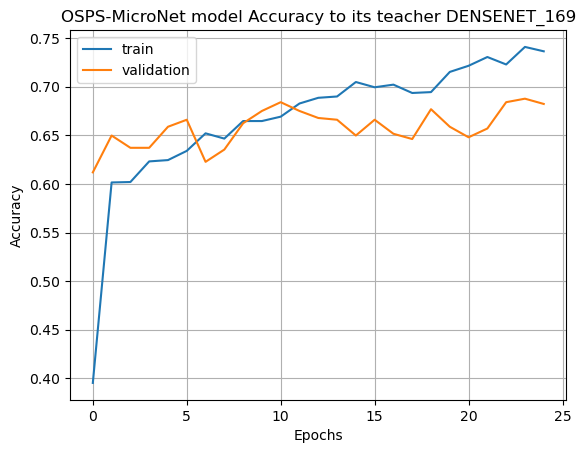

In [28]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['sparse_categorical_accuracy'])
plt.plot(graph.history['val_sparse_categorical_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('OSPS-MicroNet model Accuracy to its teacher DENSENET_169')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

In [30]:
max_acc = max(graph.history['val_sparse_categorical_accuracy'])
print('The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher DENSENET_169 model is',max_acc*100)

The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher DENSENET_169 model is 68.77256035804749


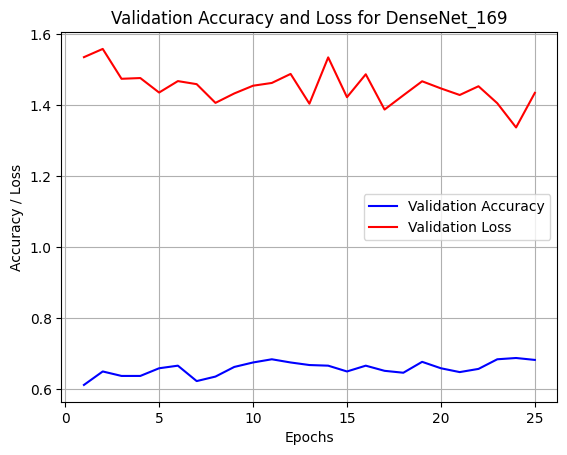

In [2]:
import matplotlib.pyplot as plt

# Validation accuracy
val_accuracy = [0.6119, 0.6498, 0.6372, 0.6372, 0.6588, 0.6661, 0.6227, 0.6354, 0.6625, 0.6751, 
                0.6841, 0.6751, 0.6679, 0.6661, 0.6498, 0.6661, 0.6516, 0.6462, 0.6769, 0.6588,
                0.6480, 0.6570, 0.6841, 0.6877, 0.6823]

# Validation loss
val_loss = [1.5347, 1.5579, 1.4738, 1.4759, 1.4351, 1.4673, 1.4587, 1.4060, 1.4325, 1.4543,
            1.4621, 1.4875, 1.4037, 1.5341, 1.4220, 1.4865, 1.3872, 1.4273, 1.4668, 1.4467,
            1.4282, 1.4528, 1.4050, 1.3368, 1.4342]

epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')

plt.title('Validation Accuracy and Loss for DenseNet_169')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')

plt.legend()
plt.grid(True)
plt.show()


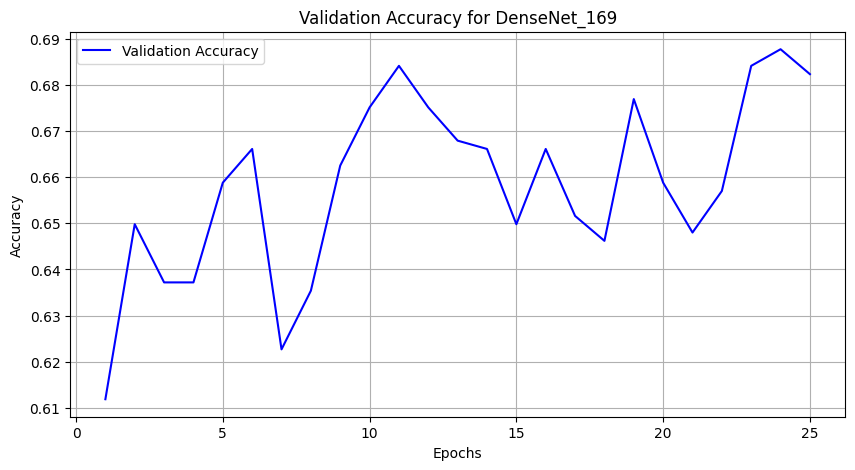

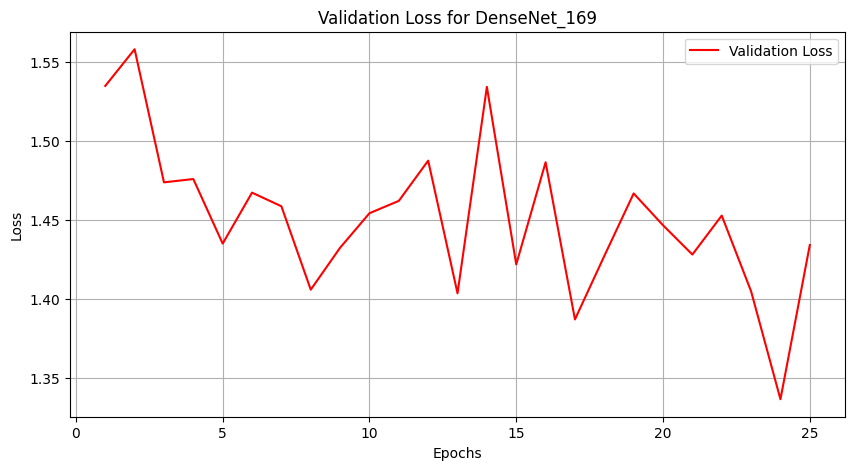

In [5]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracy) + 1)

# Plotting Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Validation Accuracy for DenseNet_169')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Validation Loss for DenseNet_169')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import matplotlib.pyplot as plt

# Set font size
plt.rcParams.update({'font.size': 20})

# Training Data
epochs = range(1, 26)
train_accuracy = [0.3953, 0.6015, 0.6020, 0.6232, 0.6245, 0.6340, 0.6521, 0.6467, 0.6647, 0.6647,
                  0.6692, 0.6828, 0.6886, 0.6900, 0.7049, 0.6995, 0.7022, 0.6936, 0.6945, 0.7153,
                  0.7216, 0.7306, 0.7229, 0.7410, 0.7365]
train_loss = [1.5695, 1.5098, 1.4946, 1.4855, 1.4851, 1.4764, 1.4775, 1.4788, 1.4668, 1.4645,
              1.4690, 1.4587, 1.4554, 1.4555, 1.4496, 1.4468, 1.4514, 1.4486, 1.4476, 1.4382,
              1.4331, 1.4279, 1.4298, 1.4220, 1.4182]

val_accuracy = [0.6119, 0.6498, 0.6372, 0.6372, 0.6588, 0.6661, 0.6227, 0.6354, 0.6625, 0.6751,
                0.6841, 0.6751, 0.6679, 0.6661, 0.6498, 0.6661, 0.6516, 0.6462, 0.6769, 0.6588,
                0.6480, 0.6570, 0.6841, 0.6877, 0.6823]
val_loss = [1.5347, 1.5579, 1.4738, 1.4759, 1.4351, 1.4673, 1.4587, 1.4060, 1.4325, 1.4543,
            1.4621, 1.4875, 1.4037, 1.5341, 1.4220, 1.4865, 1.3872, 1.4273, 1.4668, 1.4467,
            1.4282, 1.4528, 1.4050, 1.3368, 1.4342]

# Set DPI
dpi = 1080

# Combined Training Accuracy and Loss
plt.figure(figsize=(12, 6), dpi=dpi)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.title('Training Accuracy and Loss for DenseNet_169')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy_loss.png', dpi=dpi)
plt.show()

# Combined Validation Accuracy and Loss
plt.figure(figsize=(12, 6), dpi=dpi)
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Validation Accuracy and Loss for DenseNet_169')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.savefig('validation_accuracy_loss.png', dpi=dpi)
plt.show()


In [1]:
import matplotlib.pyplot as plt

# Set font size
plt.rcParams.update({'font.size': 20})

# Training Data
epochs = range(1, 26)
train_accuracy = [0.3953, 0.6015, 0.6020, 0.6232, 0.6245, 0.6340, 0.6521, 0.6467, 0.6647, 0.6647,
                  0.6692, 0.6828, 0.6886, 0.6900, 0.7049, 0.6995, 0.7022, 0.6936, 0.6945, 0.7153,
                  0.7216, 0.7306, 0.7229, 0.7410, 0.7365]
train_loss = [1.5695, 1.5098, 1.4946, 1.4855, 1.4851, 1.4764, 1.4775, 1.4788, 1.4668, 1.4645,
              1.4690, 1.4587, 1.4554, 1.4555, 1.4496, 1.4468, 1.4514, 1.4486, 1.4476, 1.4382,
              1.4331, 1.4279, 1.4298, 1.4220, 1.4182]

val_accuracy = [0.6119, 0.6498, 0.6372, 0.6372, 0.6588, 0.6661, 0.6227, 0.6354, 0.6625, 0.6751,
                0.6841, 0.6751, 0.6679, 0.6661, 0.6498, 0.6661, 0.6516, 0.6462, 0.6769, 0.6588,
                0.6480, 0.6570, 0.6841, 0.6877, 0.6823]
val_loss = [1.5347, 1.5579, 1.4738, 1.4759, 1.4351, 1.4673, 1.4587, 1.4060, 1.4325, 1.4543,
            1.4621, 1.4875, 1.4037, 1.5341, 1.4220, 1.4865, 1.3872, 1.4273, 1.4668, 1.4467,
            1.4282, 1.4528, 1.4050, 1.3368, 1.4342]

# Set DPI
dpi = 1080

# Training and Validation Accuracy
plt.figure(figsize=(12, 6), dpi=dpi)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for DenseNet_169')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_accuracy.png', dpi=dpi)
plt.show()

# Training and Validation Loss
plt.figure(figsize=(12, 6), dpi=dpi)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss for DenseNet_169')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss.png', dpi=dpi)
plt.show()
